In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%cd ..

/home/naomichi/repos/src/github.com/agatan/ocr-experiments


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from ocr.preprocessing.generator import CSVGenerator
from ocr.models import resnet50, bboxnet, mobilenet
from ocr.data import process

In [4]:
tf.keras.backend.set_session(tf.InteractiveSession())
backbone, features_pixel = mobilenet.backbone(input_shape=(512, 832, 3))
training_model, prediction_model = bboxnet.create_model(backbone, features_pixel, input_shape=(512, 832, 3), n_vocab=process.vocab())
tf.keras.backend.get_session().run(tf.global_variables_initializer())
training_model.load_weights('./checkpoint-weights.h5')
# prediction_model.get_weights()

In [5]:
# gen = CSVGenerator('./data/processed/validation/annotations.csv', features_pixel=features_pixel, input_size=(512, 832))
gen = CSVGenerator('./data/processed/train/annotations.csv', features_pixel=features_pixel, input_size=(512, 832))

In [6]:
x, y = next(gen.batches(batch_size=16))
gts = y['bbox']
gt_scores = gts[..., 0]
gt_boxes = tf.keras.backend.get_session().run(bboxnet._reconstruct_boxes(gts[..., 1:5], features_pixel=features_pixel))
gt_angles = gts[..., 5]

scores, boxes, angles, text, width = prediction_model.predict(x)

42160


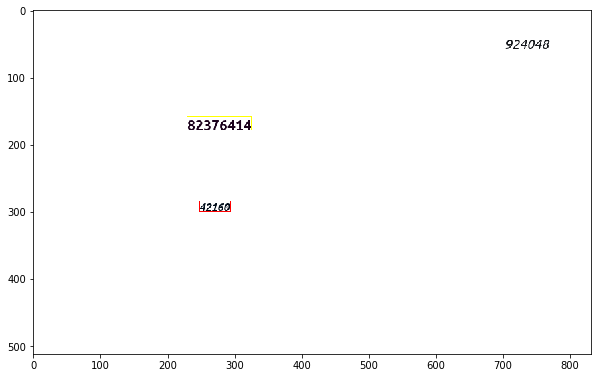

566491


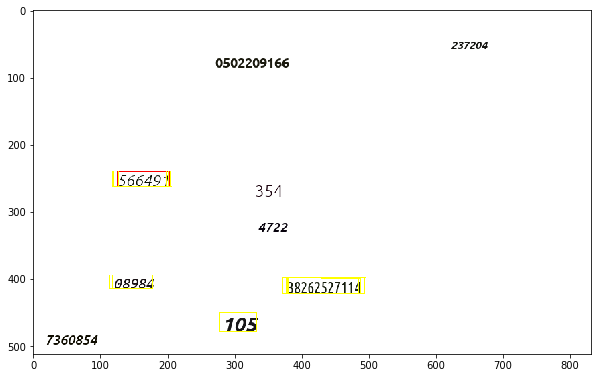

839


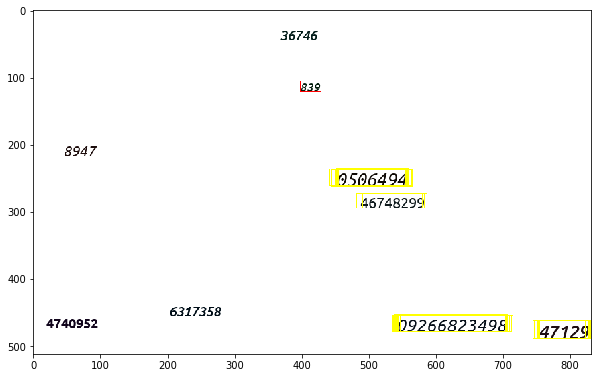

98235727144


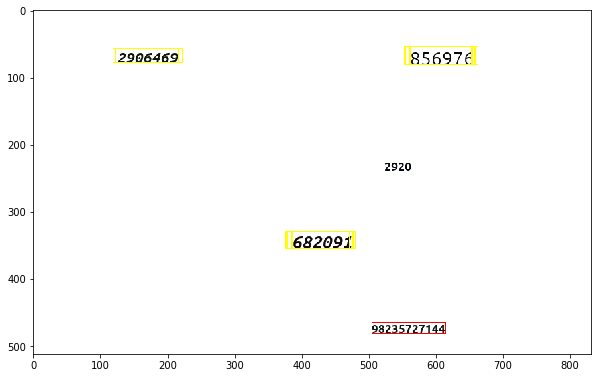

946583249


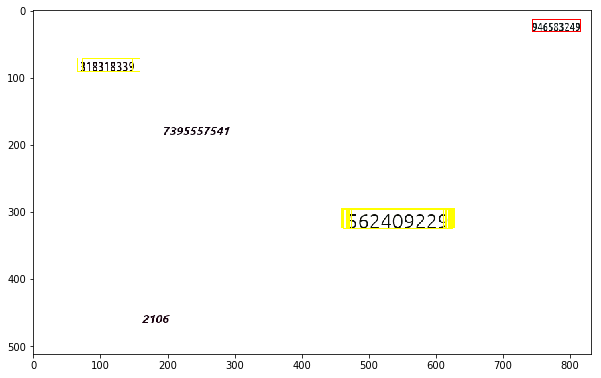

89762463


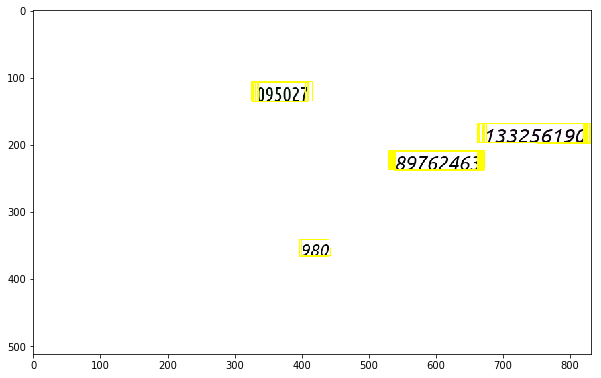

73107


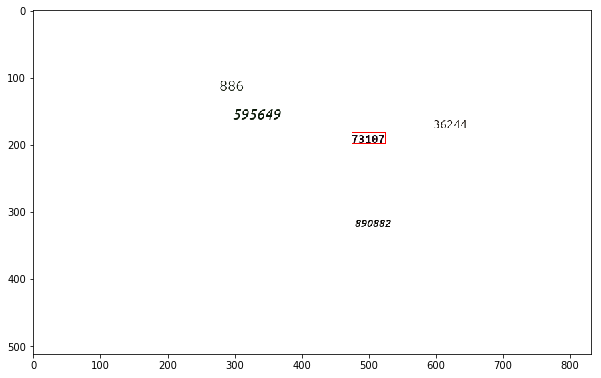

48814974


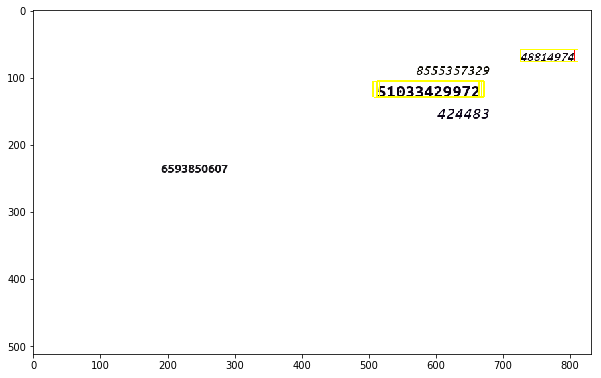

3217


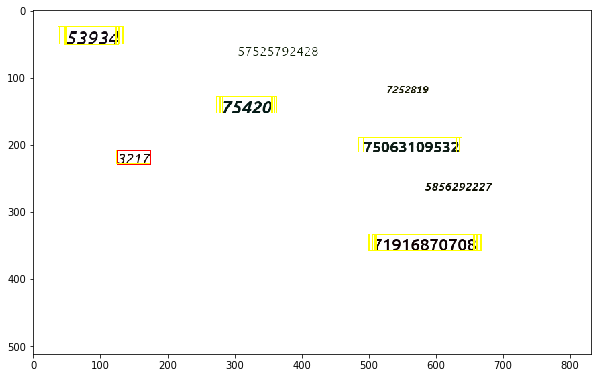

239769178


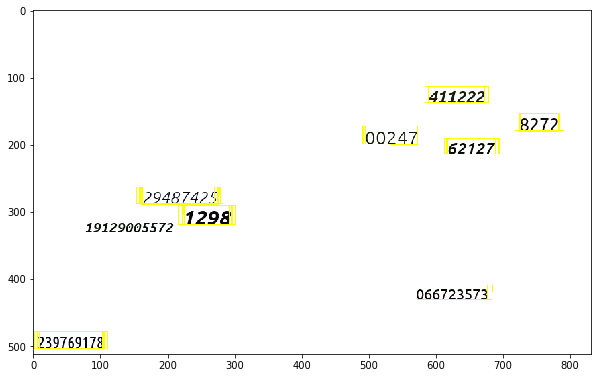

0125238133


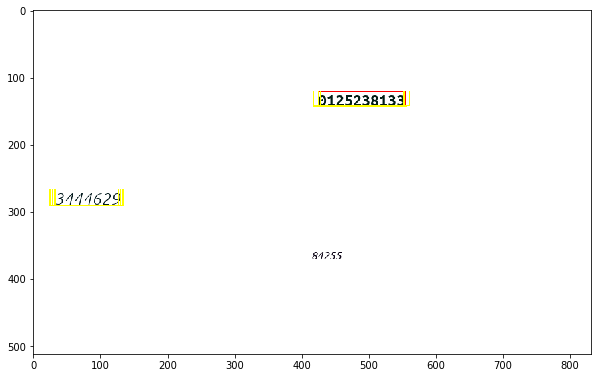

6252211


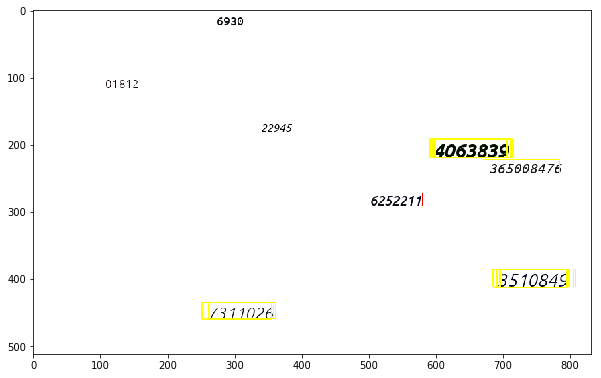

6148


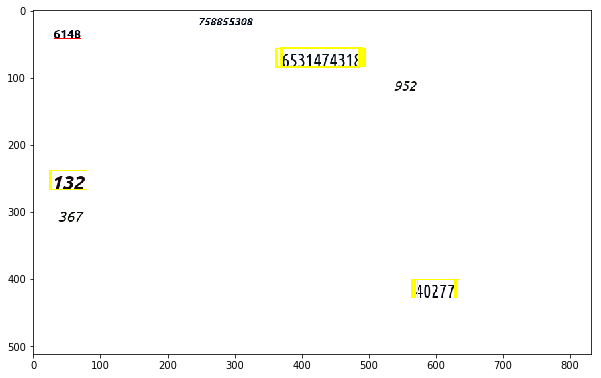

814


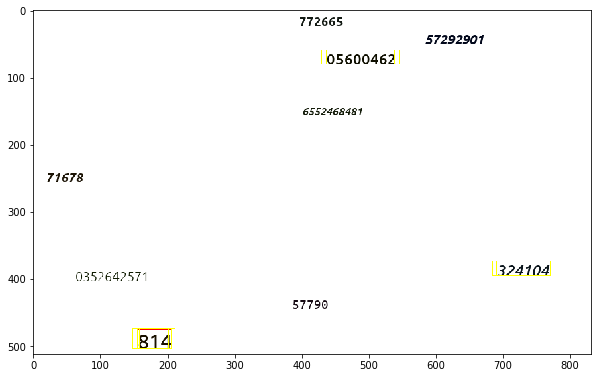

1347


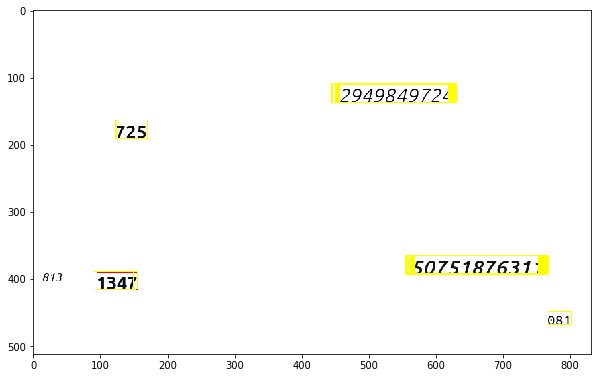

1791298


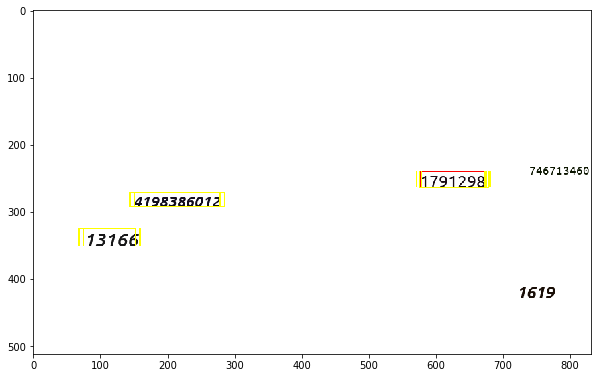

In [10]:
import random
import cv2
import math
import numpy as np
from itertools import groupby

images = x[0]
regions = x[1]

for i in range(len(images)):
    i_scores, i_boxes, i_angles = bboxnet.extract_boxes(scores[i], boxes[i], angles[i], thres=0.9)
    i_text = text[i]
    i_width = width[i]
    region = (regions[i] * features_pixel).astype(int)
    decoded = []
    argmax = np.argmax(i_text[:i_width[0]], axis=-1)
    for k, g in groupby(argmax):
        if k == process.vocab() - 1:
            continue
        decoded.append(process.idx2char(k))
    print(''.join(decoded))
    target = (images[i].copy() * 255).astype(np.int32)
    cv2.rectangle(target, (region[0], region[1]), (region[2], region[3]), (255, 0, 0))
    for (l, t, r, b), angle in zip(i_boxes, i_angles):
        theta = -angle * 90 / 180 * math.pi
        rot = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
        cx = (l + r) / 2
        cy = (t + b) / 2
        c1 = rot.dot(np.array([l - cx, t - cy])) + np.array([cx, cy])
        c2 = rot.dot(np.array([l - cx, b - cy])) + np.array([cx, cy])
        c3 = rot.dot(np.array([r - cx, b - cy])) + np.array([cx, cy])
        c4 = rot.dot(np.array([r - cx, t - cy])) + np.array([cx, cy])
        points = np.array([c1, c2, c3, c4, c1]).astype(np.int32)
        for (p1, p2) in zip(points[:5], points[1:]):
            cv2.line(target, (p1[0], p1[1]), (p2[0], p2[1]), (255, 255, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(target)
    plt.show()